# Treehugging
##
### Abstract

It can be generally agreed upon that having access to green space within your city will have a positive impact on your wellbeing, but how does this assumption appear in the data? This notebook breaks down the city of London by ward and borough. Looking at key indicators of quality of life, it presents correlations to bring insight to this statement. Measuring the p-values between factors, like life expectancy income and the control variable greenspace, gives us an idea how tied greenery is to longevity, at an individual level. Affluent areas of London have larger values of wellbeing, as well as other factors muddying what is directly responsible for these outcomes.

This analysis looks at whether investing in green space makes a reliable lever for improving wellbeing? With the evidence produced it is seen that green space is part of the makeup of wellbeing for London. However the multiple regression model is inconclusive in identifying greenspace as a factor, with wellbeing remaining hard to break down with individual statistics. By looking at life expectancy with access to green space Inside boroughs this effect is most noticeable in its individuation. It presents numerous correlations of promise that have low levels of residuals. It is hoped that these correlations can serve as evidence to improve access to greenspace and quality of life globally. 


### Introduction 

Urban green spaces tend to be associated with an improved quality of life and well-being, especially in London, where the amount of urbanity can vary significantly across its 697 wards. We felt that understanding the relationship between green spaces and well-being would be a really interesting investigation, aiming to see whether the amount of green space in London wards would positively impact the well-being of the people within those wards. By looking into factors such as life expectancy and access to green spaces, we aimed to test our hypothesis and see whether green spaces could be consistent for improving quality of life at a ward level.

Our research focuses on our alternative hypothesis - that wards with a higher percentage of green space, experience higher well-being scores - challenging the null hypothesis that there is no correlation between green space and well-being. Using data from the London Datastore, including green and blue space coverage from 2018, well-being scores from 2013, and ward profiles across 2010 to 2015, we analysed the 697 wards across 32 boroughs. We chose to do this through a multiple regression model, assessing the impact of green space alongside control variables such as age, population density, household income, crime rate, and deprivation. 
la

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import re
import sympy as sym
import geopandas as gpd
import statsmodels.api as sm

welbe = pd.read_csv('./data/london-ward-well-being-probability-scores.csv')
green = pd.read_csv('./data/green_cover_ward_summary_0.05.csv')
control = pd.read_csv('./data/ward-atlas-data.csv')
#importing csvs and modules

## Setup
### Data explanation

London is a city where most metrics for its functioning are recorded, the London Datastore has these such metrics, free to download as full datasets. Three of these datasets were chosen to conduct our analysis:
- London ward well-being probability scores (available from https://data.london.gov.uk/dataset/london-ward-well-being-scores)
- London ward green and blue cover summary (available from https://data.london.gov.uk/dataset/green-and-blue-cover)
- London ward atlas (available from https://data.london.gov.uk/dataset/ward-profiles-and-atlas)
  
These files are useful when testing the alternative hypothesis. They include data for each of London’s 697 wards, which are the primary level of English electoral geography. Each of London’s 32 boroughs is split into wards, and the majority of the data available on London Datastore can be found for both boroughs and wards. We chose ward as a smaller municipality helps improve the resolution of our data as there are more data points and a better representation of features. Due to their small area, wards are likely to have the same amount of green space distributed throughout, the ‘green cover ward summary’ dataset covers the percentage of the ward that is green space. This is useful for drawing comparisons between a ward in the city, having low levels of green space and a ward in the suburbs, where that is the opposite. 


The ‘London ward atlas’ dataset contains a vast amount of data for these wards from the early 2000’s to the present. It also contains future predictions for some variables, but these were not analysed in this project. Features like population density and median household income are vital variables when it comes to conducting the analysis plan. Models like multiple regression rely upon this trove of data, to assess correlation that could confirm the alternative hypothesis. It is also useful to visualize other correlations between these variables and wellbeing, to get a better understanding of the problem area. 


The final dataset ‘London ward well-being probability’ contains all the wellbeing data for London wards in the year 2013 as well as predictors like life expectancy, again helping with understanding the problem area. The three datasets talked about above were combined into a csv named ‘treehugbig’. This served as the dataframe that was manipulated.ated.


In [6]:
welbe = welbe.rename(columns={"New ward code": "Ward Code"})
control = control.rename(columns={"Unnamed: 1": "Ward Code"})
green = green.rename(columns={"ward_code": "Ward Code"})
treehugbig = pd.merge(welbe, control, how='outer', on=['Ward Code'])
#merging to create one large dataframe
treehugbig = treehugbig.drop([0, 1])
treehugbig = treehugbig.drop(treehugbig.index[623:])
treehugbig = treehugbig.rename(columns={"Subjective well-being average score, 2013": "WB13"})
treehugbig = treehugbig.rename(columns={"Land Use; % Greenspace; 2005": "LUG05"})
treehugbig = treehugbig.rename(columns={"Homes with access to open space & nature, and % greenspace - 2013": "OSGA13"})
treehugbig = treehugbig.rename(columns={"Household Income; Mean Modelled Household income (£); 2012/13": "HHI13"})
treehugbig = treehugbig.rename(columns={"Life Expectancy; Life expectancy at birth (all persons); 2009-2013": "LE0913"})
treehugbig = treehugbig.rename(columns={"Unauthorised Absence in All Schools (%) - 2013": "SA13"})
treehugbig = treehugbig.rename(columns={"Crime rate - 2013": "CR13"})
treehugbig = treehugbig.rename(columns={"Population and Age; Mean age; 2013": "MA13"})
treehugbig = treehugbig.rename(columns={"Area and Density; Population density (persons per sq km); 2013": "PD13"})
treehugbig = treehugbig.rename(columns={"Indices of Deprivation; Average Score; 2010": "ID10"})
#renaming columns to shorten them for easy reference
treehugbig["HHI13"] = pd.to_numeric(treehugbig["HHI13"], errors="coerce")
treehugbig["LE0913"] = pd.to_numeric(treehugbig["LE0913"], errors="coerce")
#changing dtype from string to float for regression
treehugbig.to_csv('treehugbig3.csv')

**Column codes**
- `WB13` Subjective well-being average score; 2013
- `LUG05` Land Use; % Greenspace; 2005
- `OSGA13` Homes with access to open space & nature, and % greenspace; 2013
- `HHI13` Mean Modelled Household income (£); 2012/13
- `LE0913` Life expectancy at birth (all persons); 2009-2013
- `SA13` Unauthorised Absence in All Schools (%); 2013
- `CR13` Crime rate; 2013
- `MA13` Mean age; 2013
- `PD13` Population density (persons per sq km); 2013
- `ID10` Indices of Deprivation; Average Score; 2010

### Model explanation

To investigate whether there is an association between well-being and green space in London wards, we will use a multiple regression model. The model will look at the outcome of wellbeing (`WB13`), with the main predictor being access to green space (`OSGA13`), and further variables being considered as controls. 

In our dataset, there were two variables relating to green space - `LUG05`, a measure of green space cover within a ward, and `OSGA13`, a measure of green space access for homes within a ward. The cell below shows a correlation coefficient of 0.58 and a scatterplot for these two variables, both of which suggest a moderately strong correlation. The variables are therefore have a moderate degree of collinearity, so it was important to select only one of these variables to use as our main predictor for this project. We chose to select `OSGA13`, due to the fact that access is a significant barrier to greenspace for many people, so it is important to consider this in our research.  

0.5804681158761383


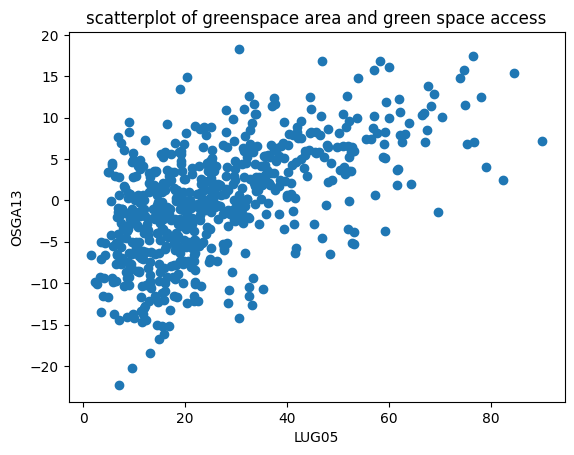

In [7]:
#correlation coefficient
print(treehugbig.LUG05.corr(treehugbig.OSGA13))

#scatterplot
plt.scatter(treehugbig.LUG05, treehugbig.OSGA13)
plt.xlabel('LUG05')
plt.ylabel('OSGA13')
plt.title('scatterplot of greenspace area and green space access')
plt.show();

### Initial exploration of the association between green space and wellbeing

To assess whether there is an association between wellbeing and greenspace (without considering any other variables), we can use a linear regression and a scatter plot. These are both shown below. 

In [8]:
#run a linear regression model
formula_string = "WB13 ~ OSGA13"

model = sm.formula.ols(formula = formula_string, data = treehugbig)
model_fitted = model.fit()

print(model_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   WB13   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.071
Date:                Thu, 03 Apr 2025   Prob (F-statistic):             0.0802
Time:                        17:15:50   Log-Likelihood:                 85.502
No. Observations:                 623   AIC:                            -167.0
Df Residuals:                     621   BIC:                            -158.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6683      0.008    905.504      0.0

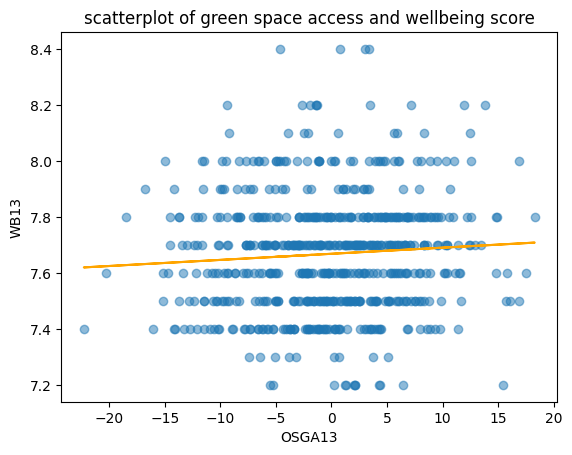

In [9]:
y_pred = model_fitted.predict(treehugbig['OSGA13'])

plt.scatter(treehugbig.OSGA13, treehugbig.WB13, alpha = 0.5)
plt.xlabel('OSGA13')
plt.ylabel('WB13')
plt.title('scatterplot of green space access and wellbeing score')
plt.plot(treehugbig['OSGA13'], y_pred, color = 'orange')

The R-squared value for access to green space (`OSGA13`) is 0.005, which means that only 0.5% of variation in wellbeing scores (`WB13`) can be explained by this predictor. The coefficient for `OSGA13` is 0.0022, meaning for every one unit increase in `OSGA13`, there is a 0.0022 unit increase in `WB13`.  However this result is not statistically significant as the p-value of 0.08 is greater than the critical value of 0.05. This means the data does not provide evidence to suggest that there is a relationship between `OSGA13` and `WB13`. 

This is supported by the scatter plot. The regression line has a slight upward slope, suggesting a very weak positive association between `OSGA13` and `WB13`. The data points are scattered widely around the regression line, suggesting that there is a weak correlation and a lot of variability in the `WB13` variable. This supports the low R-squared value (0.005), confirming that `OSGA13` explains very little of the variation in `WB13`.

We therefore face two key issues:
1. The relationship between access to green space and wellbeing scores is extremely weak, as demonstrated by the low R-squared value (0.005) and the scater plot.
2. Even if the relationship appeared stronger, the model lacks statistical significance, as the p-value (0.08) is greater than the critical value (0.05), meaning we cannot reject the null hypothesis and therefore we cannot confidently state that access to green space impacts wellbeing.

This suggests that the model may need additional predictors to capture the complexity of the relationship.
## Method
### Multiple linear regression model
To explore the complexity of the relationship, we can add some additional control predictors to the model. Before deciding on these controls, it is important to check for collinearity between the controls and the main predictor, and within the controls, in order to ensure that the variables included contribute meaningfully to the model. This can be assessed using a correlation matrix and pairwise plots, which are shown below.

In [10]:
#correlation matrix
selected_columns = ['OSGA13', 'HHI13', 'LE0913', 'SA13', 'CR13', 'MA13', 'PD13', 'ID10']
treehugbig[selected_columns].corr()

,OSGA13,HHI13,LE0913,SA13,CR13,MA13,PD13,ID10
OSGA13,1.000000,0.152419,0.053390,0.016217,-0.015673,0.138016,-0.315555,-0.018768
HHI13,0.152419,1.000000,0.569709,-0.363585,-0.090646,0.368131,0.118574,-0.449114
LE0913,0.053390,0.569709,1.000000,-0.497254,-0.359071,0.548331,-0.203016,-0.651041
SA13,0.016217,-0.363585,-0.497254,1.000000,0.370519,-0.535552,0.232252,0.683451
CR13,-0.015673,-0.090646,-0.359071,0.370519,1.000000,-0.460812,0.474166,0.555228
MA13,0.138016,0.368131,0.548331,-0.535552,-0.460812,1.000000,-0.503383,-0.753032
PD13,-0.315555,0.118574,-0.203016,0.232252,0.474166,-0.503383,1.000000,0.503054
ID10,-0.018768,-0.449114,-0.651041,0.683451,0.555228,-0.753032,0.503054,1.000000


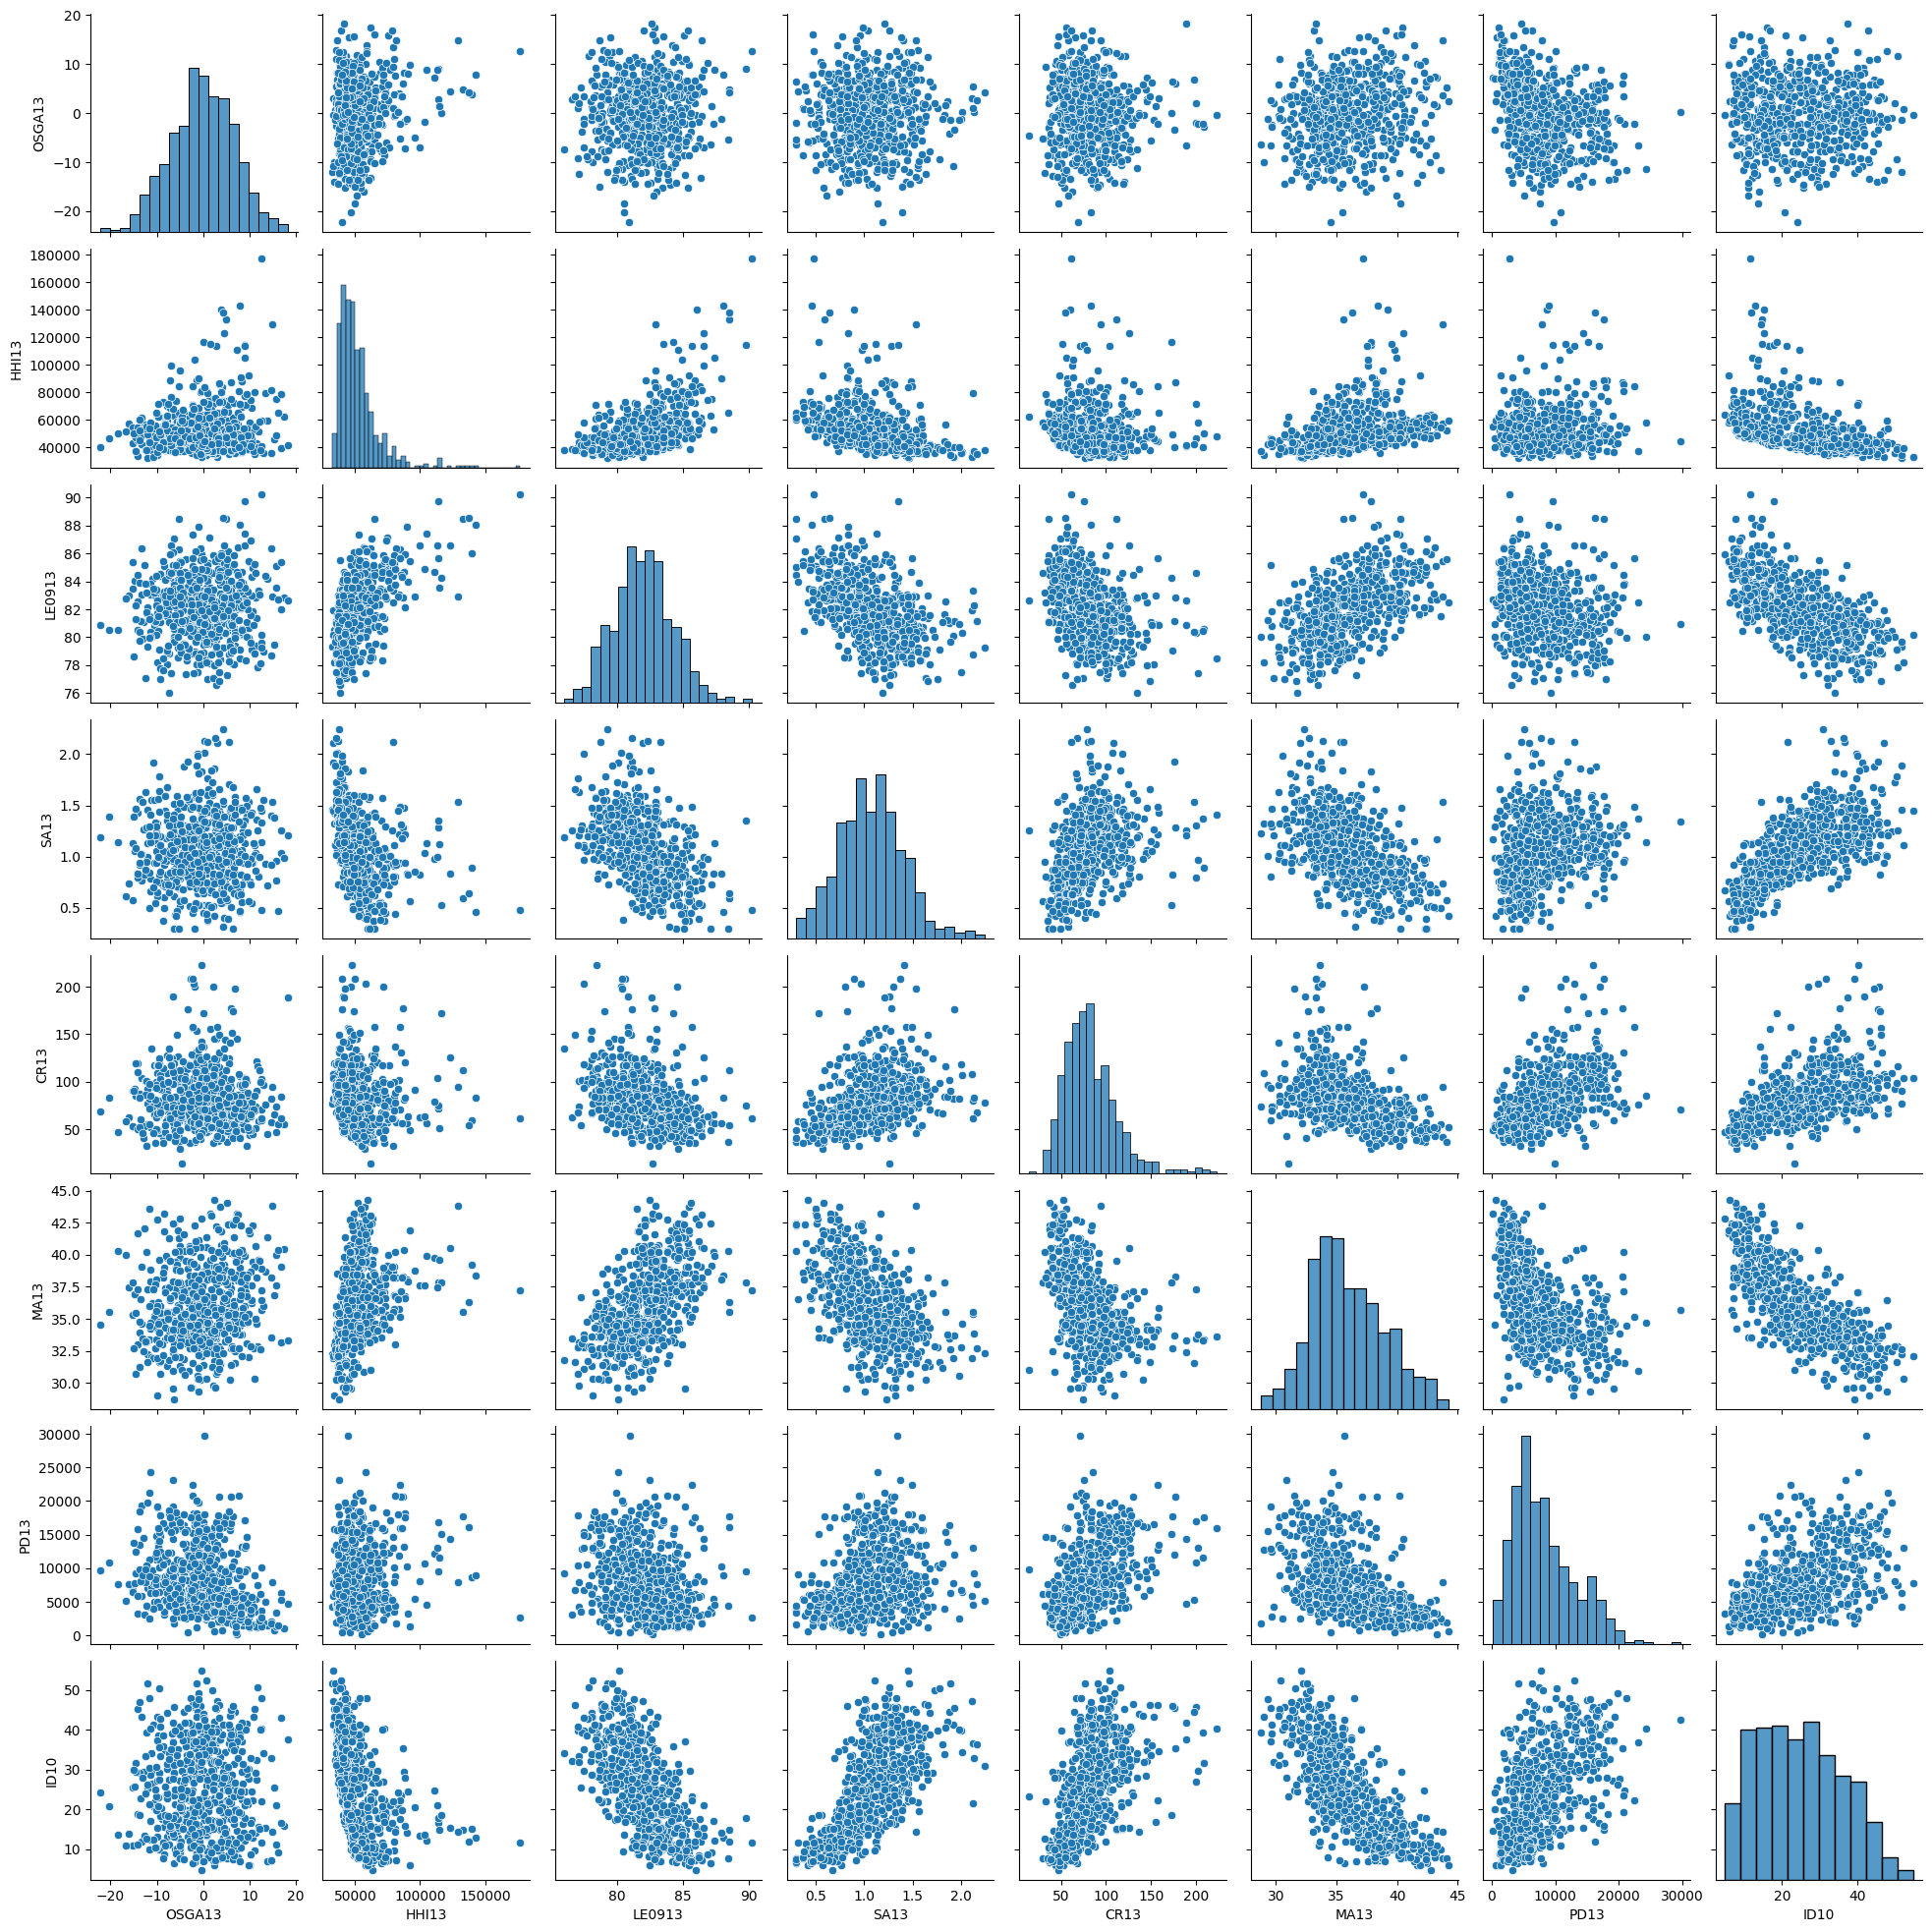

In [11]:
#pairwise plot
sns.pairplot(treehugbig[selected_columns])
plt.show();

The correlation matrix and pairwise plots show that the variable of `ID10` is correlated with all other variables to some degree, which is likely due to the fact that it is a composite measure which includes many of the other variables. Due to this collinearity, we chose to remove `ID10` from the model as it is more useful to look at the variables individually. As none of the other correlation coefficients show a strong correlation of 0.7 or above, we have not removed any other variables. 

Therefore, the control variables being included in the model are:
- `HHI13` Mean Modelled Household income (£); 2012/13
- `LE0913` Life expectancy at birth (all persons); 2009-2013
- `SA13` Unauthorised Absence in All Schools (%); 2013
- `CR13` Crime rate; 2013
- `MA13` Mean age; 2013
- `PD13` Population density (persons per sq km); 2013

Now, we can run the model again, this time including the controls listed above.

In [12]:
treehugbig.WB13.corr(treehugbig.PD13)

np.float64(0.14956417333354796)

In [13]:
#run a multiple linear regression model
formula_string = "WB13 ~ OSGA13 + HHI13 + LE0913 + SA13 + CR13 + MA13 + PD13"

model = sm.formula.ols(formula = formula_string, data = treehugbig)
model_fitted = model.fit()

print(model_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   WB13   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     7.696
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           6.24e-09
Time:                        17:15:58   Log-Likelihood:                 110.12
No. Observations:                 623   AIC:                            -204.2
Df Residuals:                     615   BIC:                            -168.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1898      0.419     21.959      0.0

The adjusted R-squared value is 0.070, suggesting access to green space (`OSGA13`) can explain 7% of variation in wellbeing scores (`WB13`), when `HHI13`, `LE0913`, `SA13`, `CR13`, `MA13` and `PD13` are held constant. While this is an increase from the R-squared value of 0.005 from the simple linear regression that we ran earlier, the R-squared value is still low, and can explain little of the data.

Furthermore, when looking at the p-values in the table, `SA13` and `MA13` are not statistically significant, as their p-values are greater than the critical value of 0.05. We can use backwards stepwise selection to remove these variables, starting from the highest p-value and working down until all the p-values are staatistically significant, and check whether this has an impact on the R-squared value.

In [14]:
#run a multiple linear regression model
formula_string = "WB13 ~ OSGA13 + HHI13 + LE0913 + CR13 + PD13"

model = sm.formula.ols(formula = formula_string, data = treehugbig)
model_fitted = model.fit()

print(model_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   WB13   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     10.50
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           1.09e-09
Time:                        17:15:58   Log-Likelihood:                 109.40
No. Observations:                 623   AIC:                            -206.8
Df Residuals:                     617   BIC:                            -180.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.2554      0.391     23.681      0.0

When the non-significant variables are removed, the adjusted R-squared value increases from 0.070 to 0.071. Although the increase in adjusted R-squared value is an incredibly small difference, carrying out this process of backwards stepwise selection is still useful, as it streamlines the model and identifies the most important predictors. 

However, the adjusted R-squared value is still low overall, so even when considering important control variables, access to green space (`OSGA13`) can still only explain 7.1% of variation in wellbeing scores (`WB13`). This means the model's predictive power is limited, as 92.9% of variation in wellbeing scores remains unexplained by the variables included. It is therefore likely that there other other important variables that influence wellbeing that are not included in the model. 

## Further data exploration 
The following data does not directly answer the research question, but is helpful for understanding the topic and visualising the relationships between variables discussed earlier. 

Our research question focuses on variables at a ward level, but the dataset included the borough each ward is located in. If we look at the data on a more zoomed out level by focusing on variation between boroughs rather than ward, the results look different. 

In [15]:
#creates a function that returns a dataframe for a borough specified in the argument
def boroughing(borough):
    bordata = treehugbig[treehugbig['Borough'] == borough]
    return bordata

In [16]:
#run a multiple linear regression for one specific borough
import statsmodels.api as sm

formula_string = "WB13 ~ OSGA13 + HHI13"

model = sm.formula.ols(formula = formula_string, data = boroughing('Hounslow'))
model_fitted = model.fit()

print(model_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   WB13   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     9.082
Date:                Thu, 03 Apr 2025   Prob (F-statistic):            0.00208
Time:                        17:15:58   Log-Likelihood:                 27.818
No. Observations:                  20   AIC:                            -49.64
Df Residuals:                      17   BIC:                            -46.65
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2269      0.078     92.215      0.0

The measure of wellbeing score does not vary greatly between boroughs - the highest score in the dataset is 8.4, and the lowest is 7.2 - only a 1.2 point range in scores. However, other variables have a greater variation, such as life expectancy (`LE0913`), which varies from 75.98 to 90.26 - a range of 14.28 years. A higher level of variation makes it easier to visualise differences between areas, and since health is a part of wellbeing, and life expectancy is an indicator of health, it is interesting to look at the variation in life expectancy between boroughs (borough level was chosen to simplify the visualisation and provide a more manageable number of results).

The cell below shows scatter plots of the correlation between access to green space (`OSGA`) and life expectancy (`LE0913`) in each borough.
**Note:** we were unable to get the final part of the code to work, but it should compare the correlations between the `OSGA` and `LE0913` for each borough, to identify whether there are any similarities between boroughs which have a positive correlation and boroughs which have a negative correlation. . 

/opt/conda/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


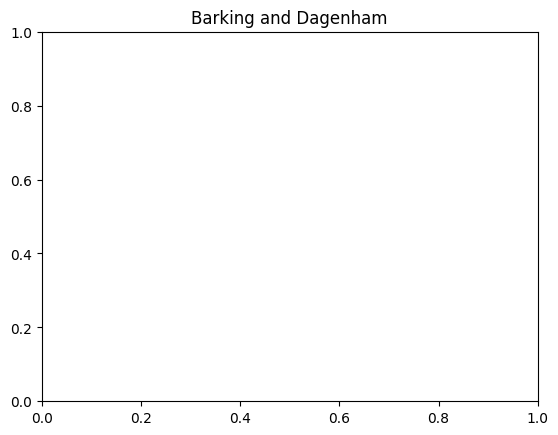

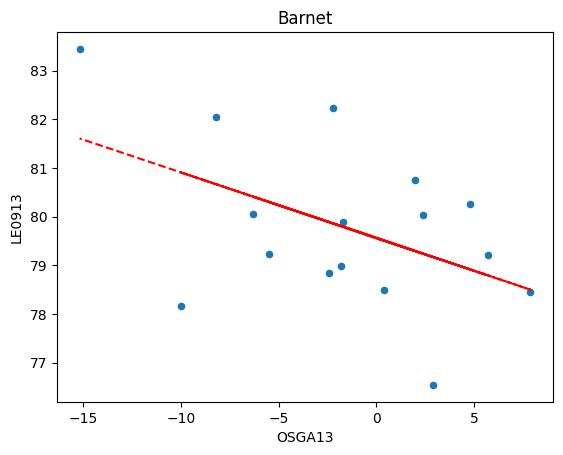

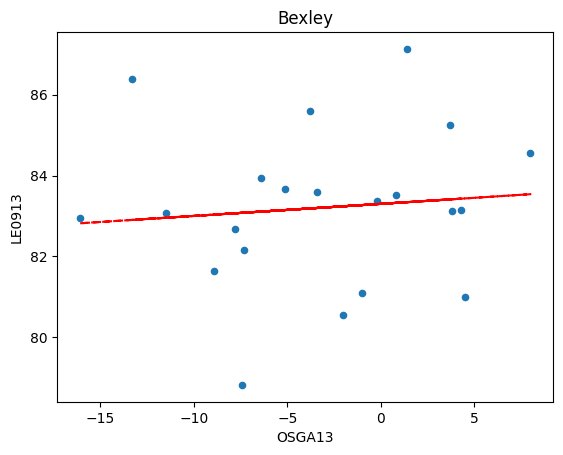

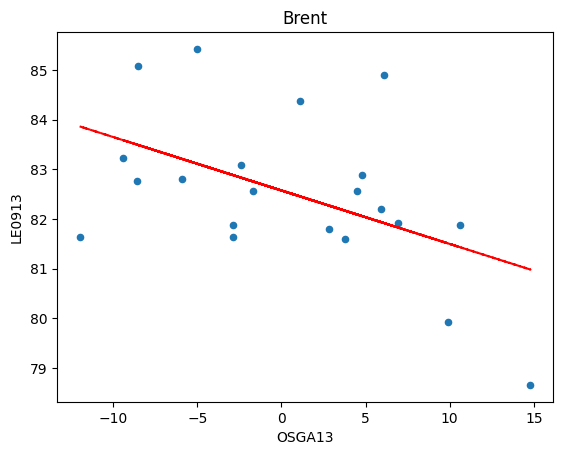

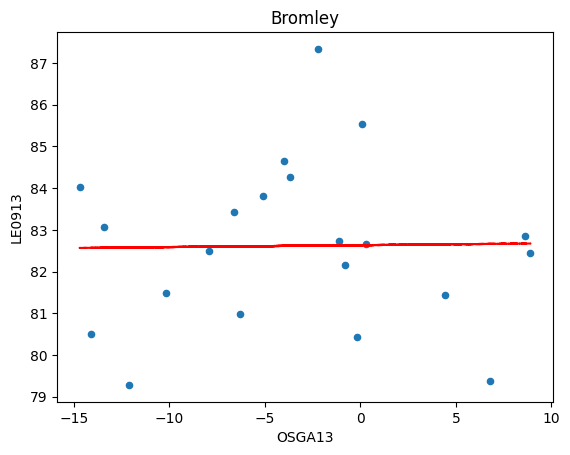

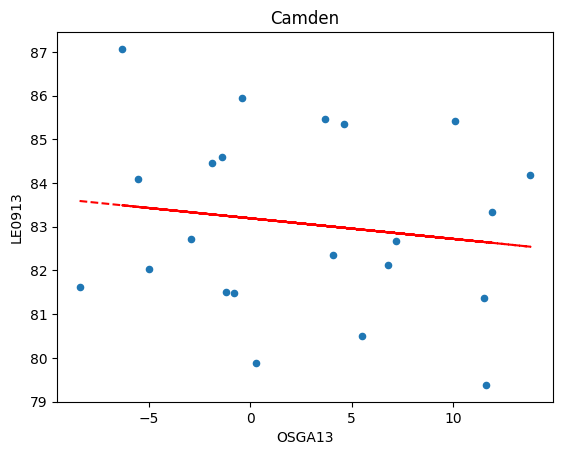

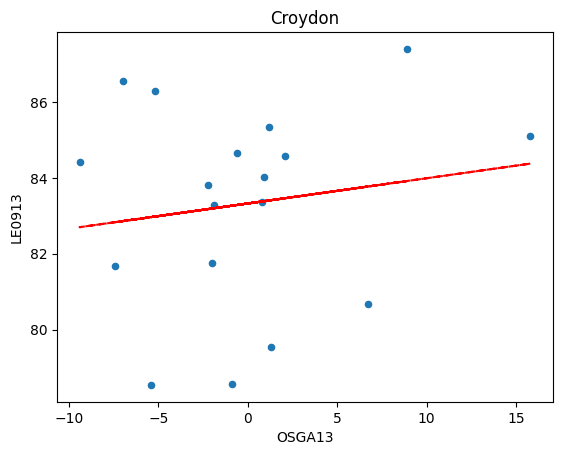

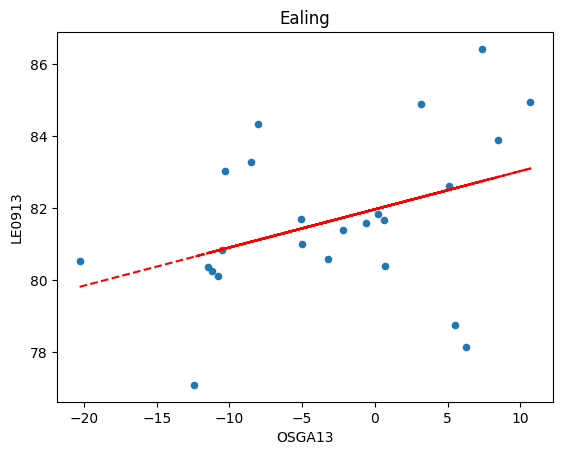

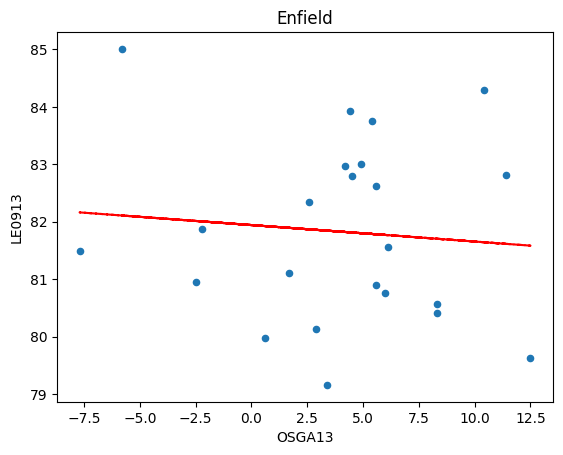

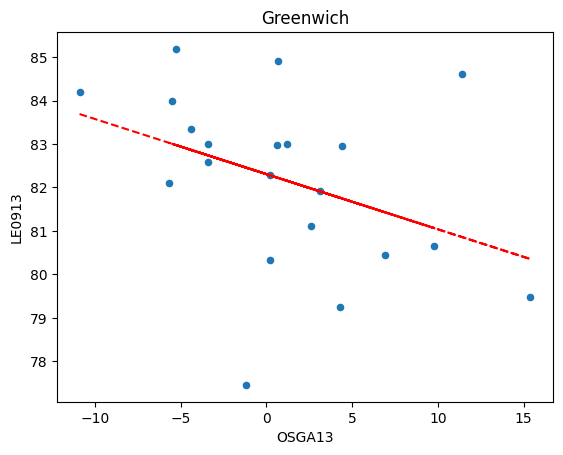

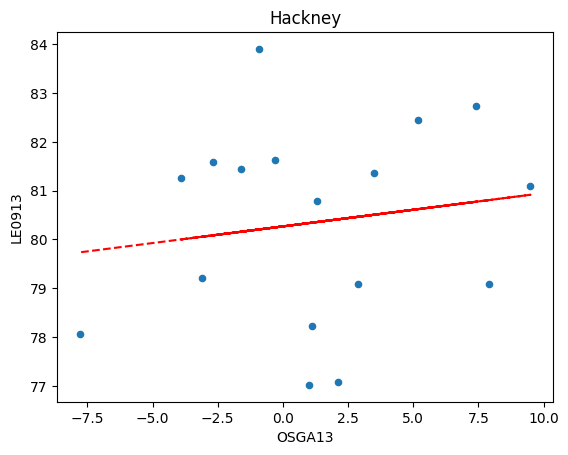

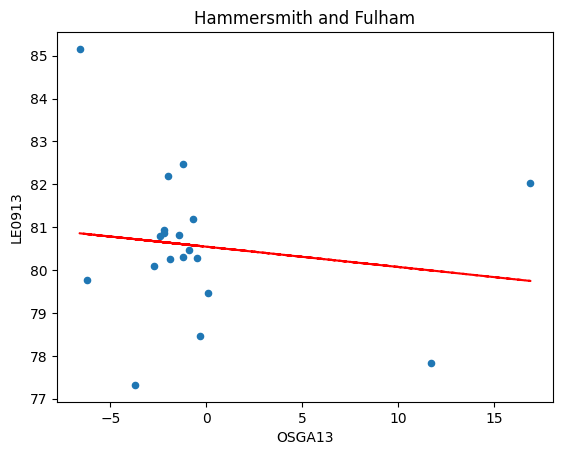

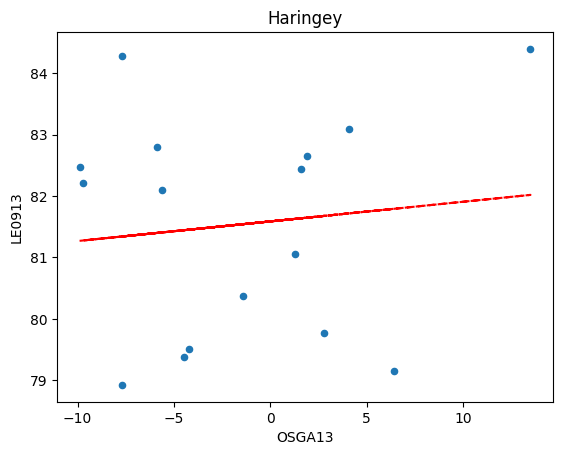

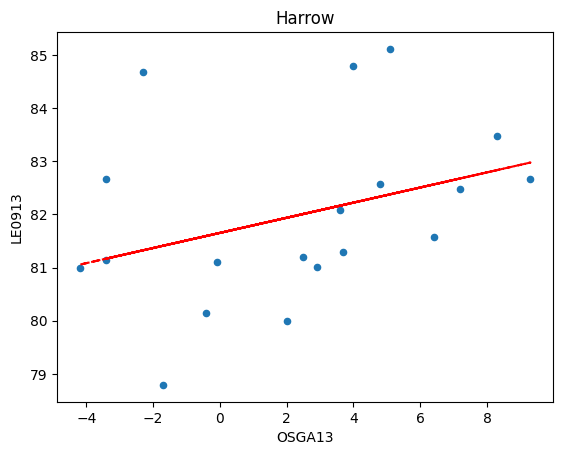

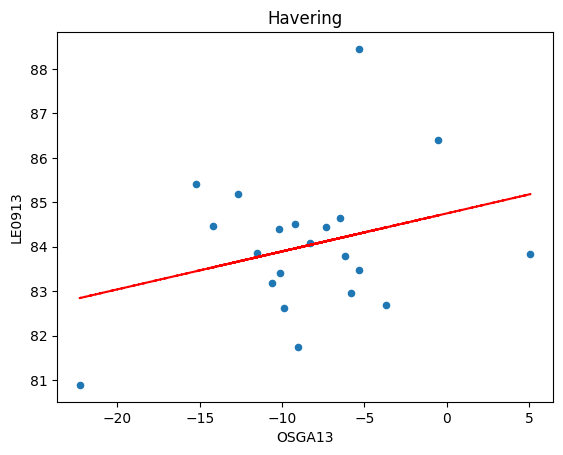

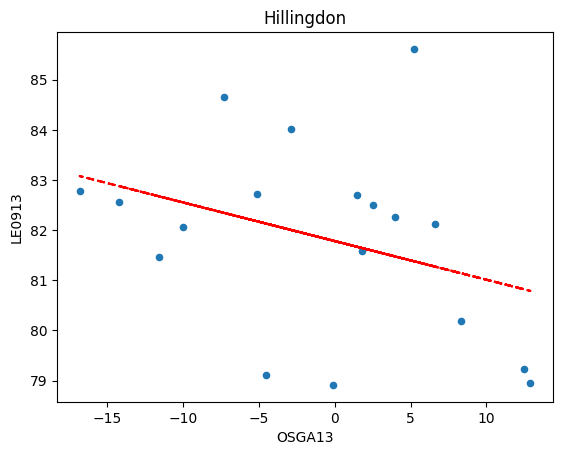

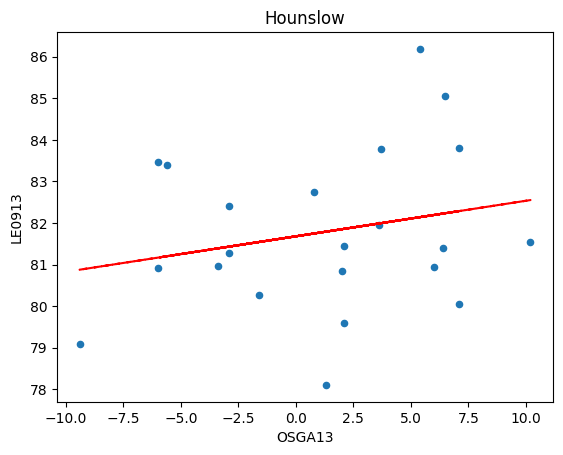

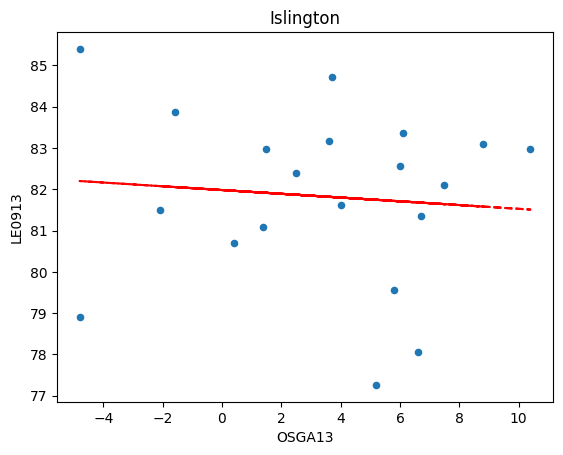

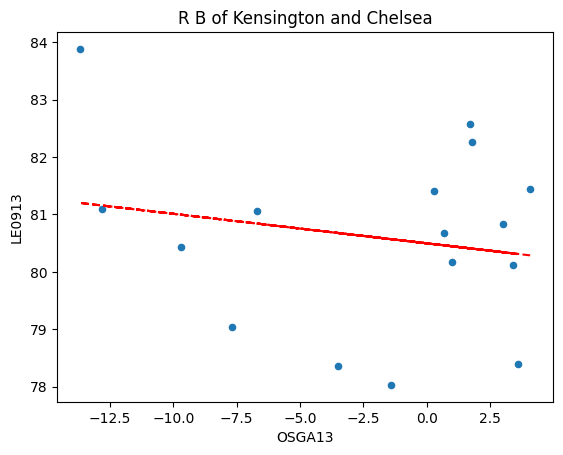

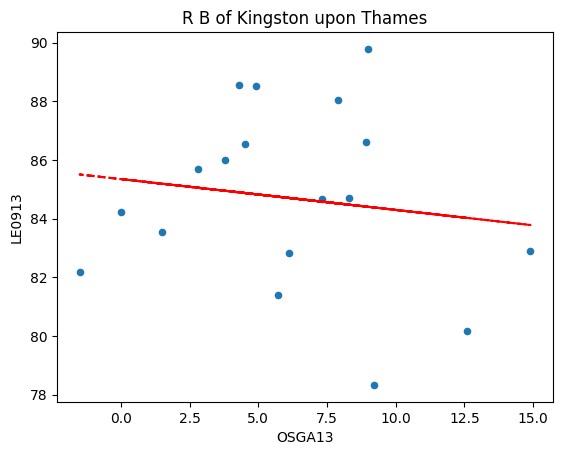

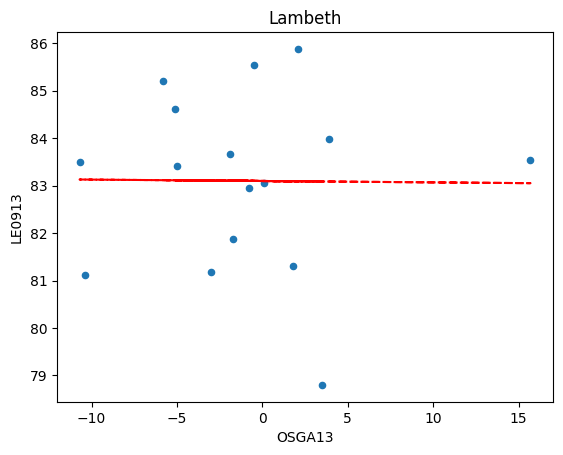

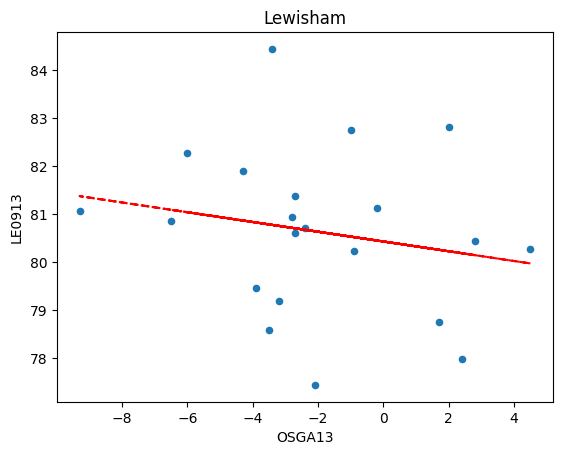

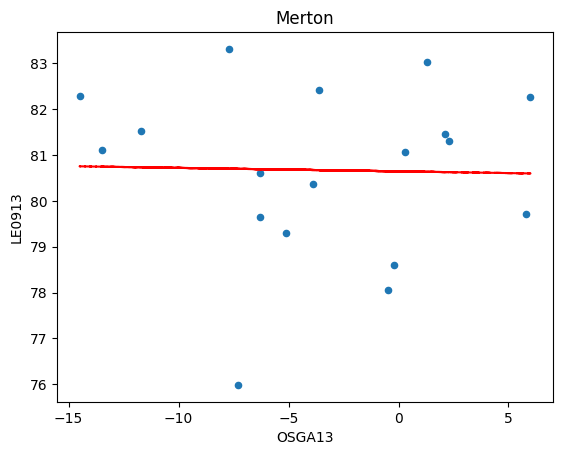

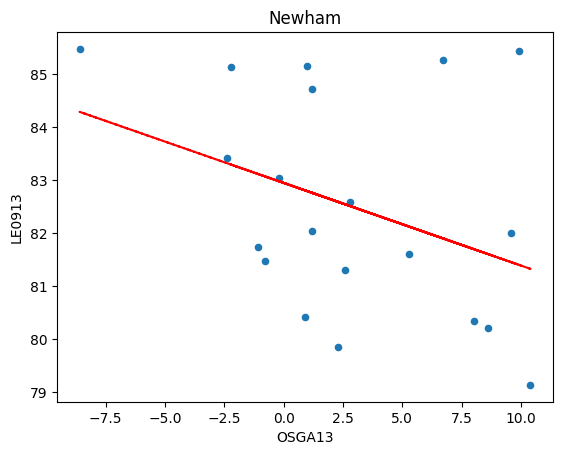

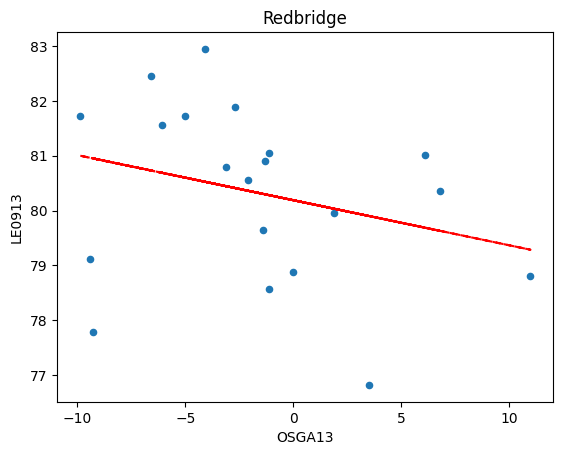

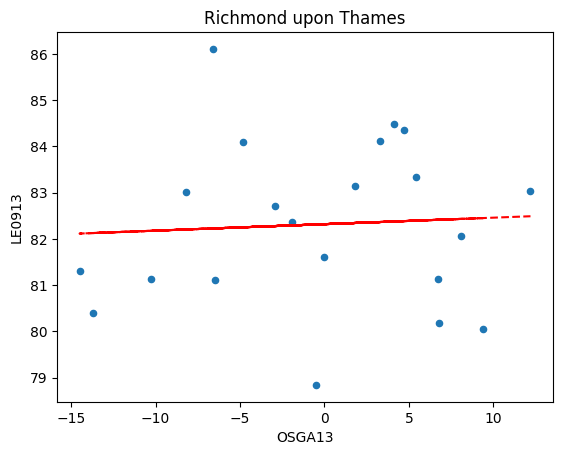

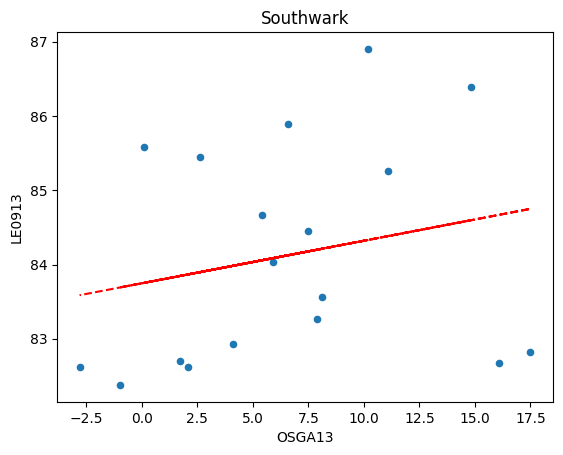

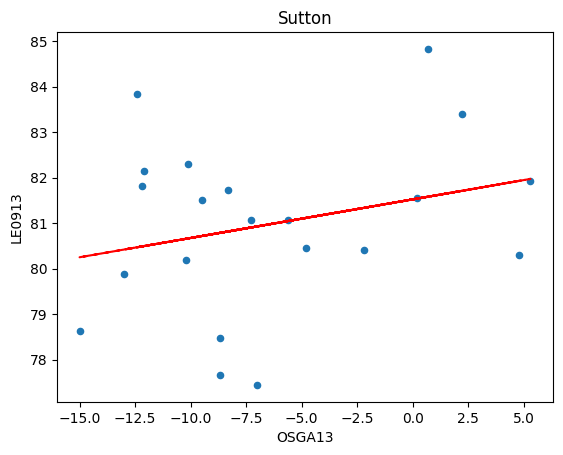

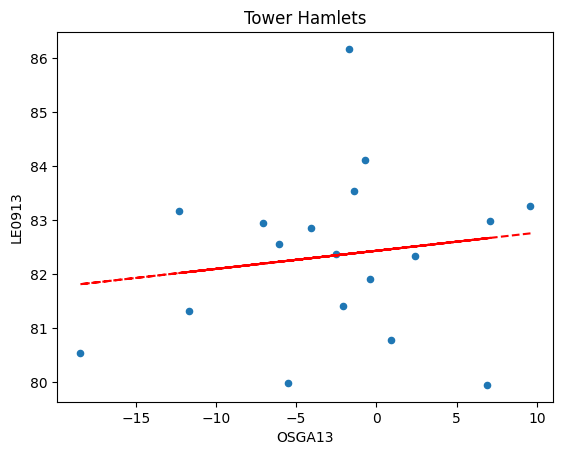

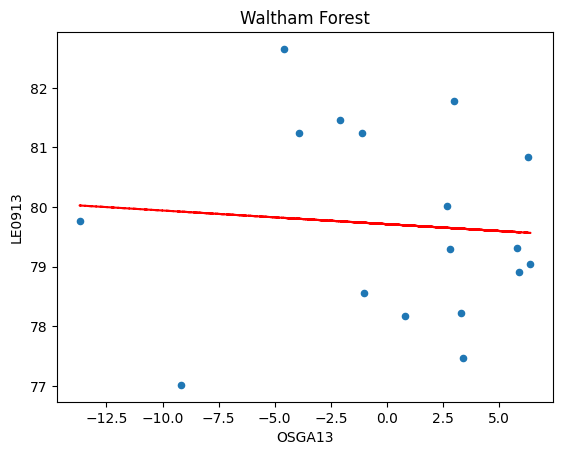

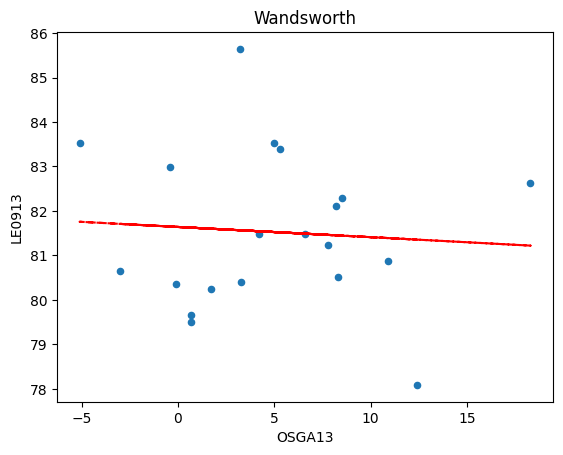

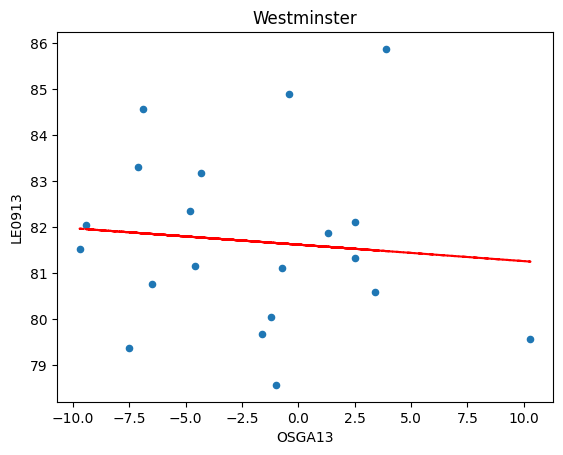

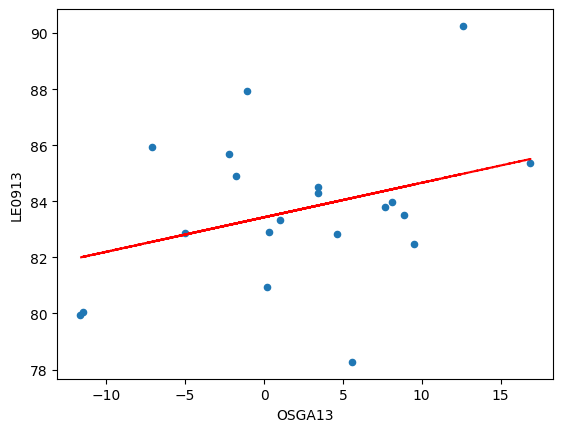

In [17]:
#this code generates a graph of correlation between life expectancy and access to green space for every borough
borarr = treehugbig['Borough'].unique()
#d={}
i=0
borser = pd.Series(borarr)
for i in range(len(borser)):
    selbor = borser.iloc[i]
    plt.title(selbor)
    boroughing(selbor).plot.scatter(x = 'OSGA13', y = 'LE0913')
    z = np.polyfit(boroughing(selbor)['OSGA13'], boroughing(selbor)['LE0913'], 1)
    p = np.poly1d(z)
    plt.plot(boroughing(selbor)['OSGA13'],p(boroughing(selbor)['OSGA13']),"r--")
#    d["borgrad"+str(i)] = p
    i = i+1
    
#bors = pd.DataFrame()
#borgradlist = list(d.values())
#[float(i) for i in borgradlist]
#for i in range(len(bors)):
#    borgrad = re.findall('\d+\.\d+', bors['borgrad'].iloc[i])
#could never get this code working. How do you turn poly1d into float?!?!?! 

Finally, let's take a look at maps of London Boroughs representing our variables of interest. For this we use Geopandas to merge a .shp map of London Boroughs with our original dataset .csv. We will also have to do some cleaning, as the names for Kensington and Chelsea are different across the two datasets, and so must be standardised before merging.

Text(0.5, 1.0, 'Wellbeing (from 1-10) by London Borough')

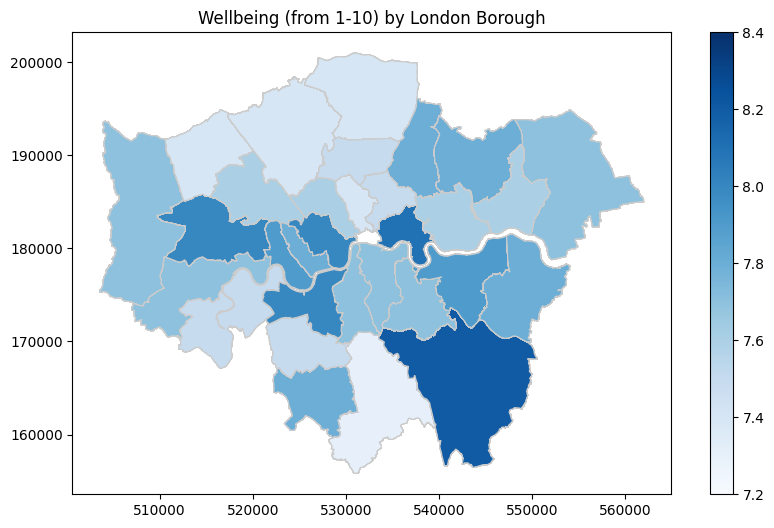

In [39]:
treehugbig = treehugbig.replace("R B of Kensington and Chelsea", "Kensington and Chelsea")
fp = './data/geo/London_Borough_Excluding_MHW.shp'
map_df = gpd.read_file(fp)
thmap = map_df.set_index('NAME').join(treehugbig.set_index('Borough'))
thmap.to_csv('thmap.csv')
# setting variables for visualisation
gs = 'OSGA13'
wb = 'WB13'
# setting range 
vmin, vmax = 120, 220
# creating the graph in Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
wbmap = thmap.plot(column=wb, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
wbmap.set_title('Wellbeing (from 1-10) by London Borough')

Text(0.5, 1.0, 'Homes with Access to Green Space (%) by London Borough')

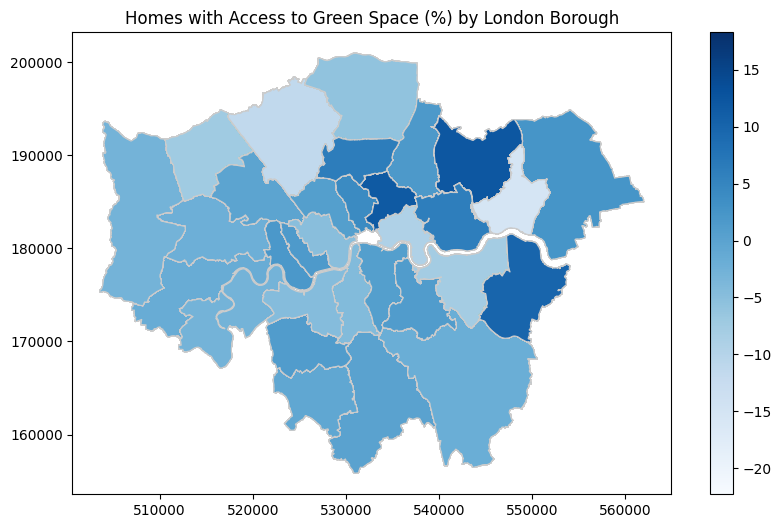

In [20]:
vmin, vmax = 120, 220

fig, ax = plt.subplots(1, figsize=(10, 6))
gsmap = thmap.plot(column=gs, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
gsmap.set_title('Homes with Access to Green Space (%) by London Borough')

These maps represent our data in an easily intuitive way, and shows us something interesting. In some boroughs like Redbridge, the access to green space is positively correlated with wellbeing, whereas boroughs like Tower Hamlets are negatively correalated. This could be down to probability, but to identify the causes behind this much more further analysis and research is required.

## Results
The simple linear regression looking at the link between green space access and wellbeing across London wards showed almost no relationship, with an R-squared of 0.005, meaning green space access explains only 0.5% of wellbeing variation. The coefficient for was minuscule (0.0022), and with a p-value of 0.080 (p > 0.05), and therefore wasnt statistically significant. A scatter plot backed this up, showing a weak upward trend.

Adding our control variables - household income, life expectancy, crime rate, mean age, and population density - in a multiple linear regression improved the model slightly, with an R-squared of 0.081. Although, still, green space access was insignificant (coefficient = 0.0014, p = 0.265), while income, life expectancy, and population density were significant. We can see the model explained 51.7% of wellbeing variation (R-squared = 0.517), with income being significant, but green space access still had no effect (p = 0.508).


## Conclusion
This study questioned whether green spaces increase wellbeing in London wards, but our results were insignificant, leading us to accept our null hypothesis. Instead, factors like household income and population density were a focus instead, flagging as significant influences of wellbeing. This suggests that, in London, people’s socio-economic condition, impacts wellbeing more than green spaces do. 
The study’s limitations, like using 2013 data, mean we should be cautious with our results. In future research, we could use newer data, check other boroughs, or test other variables such as pollution. 